In [3]:
import pandas as pd
import numpy as np
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [ ]:
ari_incidence = pd.read_csv("latest-ARI_incidence.csv",sep=',')
ili_incidence = pd.read_csv("latest-ILI_incidence.csv",sep=',')

In [ ]:
ari_incidence.head()

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [ ]:
url = "https://archive-api.open-meteo.com/v1/archive"

In [ ]:
#capitals ARI
params_ari = {
    "latitude": [50.8503, 42.6977, 50.0755, 52.52, 59.437, 40.4168, 48.8566, 47.4979, 54.6872, 49.8153, 56.9496, 44.4268, 46.0569],
    "longitude": [4.3517, 23.3219, 14.4378, 13.405, 24.7536, -3.7038, 2.3522, 19.0402, 25.2797, 6.1296, 24.1052, 26.1025, 14.5058],
    "hourly": "relative_humidity_2m",
    "timezone": "auto",
    "start_date": "2014-10-05",
    "end_date": "2024-10-13"
}
country_names_ari = [
    "BE", "BG", "CZ", "DE", "EE",
    "ES", "FR", "HU", "LT", "LU",
    "LV", "RO", "SI"
]



In [ ]:
ari_incidence = ari_incidence[ari_incidence['location'].isin(country_names_ari)]
ari_incidence.groupby('location').count()

In [ ]:

responses = openmeteo.weather_api(url, params=params_ari) 
all_data_ari = []

# Loop through all responses
for country, response in zip(country_names_ari, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the hourly data
    hourly = response.Hourly()
    hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()

    # Create a DataFrame for the current location
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "relative_humidity_2m": hourly_relative_humidity_2m,
        "country": [country] * len(hourly_relative_humidity_2m)  # Add country column
    }

    all_data_ari.append(pd.DataFrame(data=hourly_data))

data_ari_humidity = pd.concat(all_data_ari, ignore_index=True)


# Optionally save to CSV
data_ari_humidity.to_csv("data_humidity_ari.csv", index=False)


In [ ]:
data_ari_humidity.groupby('country').count()

In [ ]:
params_ari_temp = {
 	"latitude": [50.8503, 42.6977, 50.0755, 52.52, 59.437, 40.4168, 48.8566, 47.4979, 54.6872, 49.8153, 56.9496, 44.4268, 46.0569],
    "longitude": [4.3517, 23.3219, 14.4378, 13.405, 24.7536, -3.7038, 2.3522, 19.0402, 25.2797, 6.1296, 24.1052, 26.1025, 14.5058],
	"daily": ["temperature_2m_max", "temperature_2m_min"],
	"timezone": "auto",
	"start_date": "2014-10-05",
	"end_date": "2024-10-13"
}

In [ ]:

responses = openmeteo.weather_api(url, params=params_ari_temp) 
all_data_temp_ari = []

# Loop through all responses
for country, response in zip(country_names_ari, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the daily data
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()

    # Create a DataFrame for the current location
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "temperature_2m_max": daily_temperature_2m_max,
        "temperature_2m_min": daily_temperature_2m_min,
        "country": [country] * len(daily_temperature_2m_max)  # Add country column
    }

    # Convert to DataFrame and append to the list
    all_data_temp_ari.append(pd.DataFrame(data=daily_data))

data_temp_ari = pd.concat(all_data_temp_ari, ignore_index=True)

data_temp_ari.to_csv("data_temp_ari.csv", index=False)


In [ ]:
data_temp_ari.groupby('country').count()

In [ ]:
#params for ili humidity
params_ili = {
    "latitude": [
        47.5162, 50.8503, 50.0755, 55.6761, 59.437,
        48.8566, 37.9838, 45.815, 47.4979, 53.3498,
        54.6872, 49.8153, 56.9496, 35.8997, 52.3676,
        59.9139, 52.2297, 44.4268, 46.0569
    ],
    "longitude": [
        14.5501, 4.3517, 14.4378, 12.5683, 24.7536,
        2.3522, 23.7275, 15.9819, 19.0402, -6.2603,
        25.2797, 6.1296, 24.1052, 14.5146, 4.9041,
        10.7522, 21.0122, 26.1025, 14.5058
    ],
    "hourly": "relative_humidity_2m",
    "timezone": "auto",
    "start_date": "2014-10-05",
    "end_date": "2024-10-13"
}
country_names_ili = [
    "AT","BE","CZ","DK",
    "EE","FR","GR","HR",
    "HU","IE","LT","LU",
    "LV","MT","NL","NO",
    "PL","RO","SI"
]


In [ ]:
ili_incidence = ili_incidence[ili_incidence['location'].isin(country_names_ili)]
ili_incidence.groupby('location').count()

In [ ]:
"""
responses = openmeteo.weather_api(url, params=params_ili) 
all_data_ili = []

for country, response in zip(country_names_ili, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the hourly data
    hourly = response.Hourly()
    hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()

    # Create a DataFrame for the current location
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "relative_humidity_2m": hourly_relative_humidity_2m,
        "country": [country] * len(hourly_relative_humidity_2m)  # Add country column
    }

    # Convert to DataFrame and append to the list
    all_data_ili.append(pd.DataFrame(data=hourly_data))

data_ili_humidity = pd.concat(all_data_ili, ignore_index=True)

data_ili_humidity.to_csv("data_humidity_ili .csv", index=False)
"""

In [ ]:
import time

responses = openmeteo.weather_api(url, params=params_ili) 
all_data_ili = []

for country, response in zip(country_names_ili, responses):
    if response is None:
        print(f"No data available for {country}.")
        continue

    hourly = response.Hourly()
    hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy()
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=hourly.Interval()),
            inclusive="left"
        ),
        "relative_humidity_2m": hourly_relative_humidity_2m,
        "country": [country] * len(hourly_relative_humidity_2m)
    }

    all_data_ili.append(pd.DataFrame(data=hourly_data))
    # Wait a bit before the next request to avoid rate limiting
    time.sleep(5)  # adjust the delay as needed

data_ili_humidity = pd.concat(all_data_ili, ignore_index=True)
data_ili_humidity.to_csv("data_humidity_ili.csv", index=False)


In [ ]:
data_ili_humidity.groupby('country').count()

In [ ]:
#params for temp ili
params_ili_temp = {
    "latitude": [
        47.5162, 50.8503, 50.0755, 55.6761, 59.437,
        48.8566, 37.9838, 45.815, 47.4979, 53.3498,
        54.6872, 49.8153, 56.9496, 35.8997, 52.3676,
        59.9139, 52.2297, 44.4268, 46.0569
    ],
    "longitude": [
        14.5501, 4.3517, 14.4378, 12.5683, 24.7536,
        2.3522, 23.7275, 15.9819, 19.0402, -6.2603,
        25.2797, 6.1296, 24.1052, 14.5146, 4.9041,
        10.7522, 21.0122, 26.1025, 14.5058
    ],
	"daily": ["temperature_2m_max", "temperature_2m_min"],
	"timezone": "auto",
	"start_date": "2014-10-05",
	"end_date": "2024-10-13"
}

In [ ]:

responses = openmeteo.weather_api(url, params=params_ili_temp)  
all_data_temp_ili = []

for country, response in zip(country_names_ili, responses):
    # Check if the response is valid
    if response is None:
        print(f"No data available for {country}.")
        continue

    # Process the daily data
    daily = response.Daily()
    daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
    daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()

    # Create a DataFrame for the current location
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "temperature_2m_max": daily_temperature_2m_max,
        "temperature_2m_min": daily_temperature_2m_min,
        "country": [country] * len(daily_temperature_2m_max)  # Add country column
    }

    # Convert to DataFrame and append to the list
    all_data_temp_ili.append(pd.DataFrame(data=daily_data))

# Combine all DataFrames into one
data_temp_ili = pd.concat(all_data_temp_ili, ignore_index=True)

# Optionally save to CSV
data_temp_ili.to_csv("data_temp_ili.csv", index=False)


In [ ]:
data_temp_ili.groupby('country').count()

In [ ]:
data_ari_humidity.dtypes

In [ ]:
data_ari_humidity['Fecha'] = data_ari_humidity['date'].dt.strftime('%Y-%m-%d')
data_ili_humidity['Fecha'] = data_ili_humidity['date'].dt.strftime('%Y-%m-%d')
data_temp_ari['Fecha'] = data_temp_ari['date'].dt.strftime('%Y-%m-%d')
data_temp_ili['Fecha'] = data_temp_ili['date'].dt.strftime('%Y-%m-%d')

In [ ]:
data_ari_humidity.head()

In [ ]:
data_ari_humidity.columns

In [ ]:
#mean by day for humidity
data_ili_hum_by_day = data_ili_humidity[['relative_humidity_2m', 'country', 'Fecha']].groupby(['country', 'Fecha'])['relative_humidity_2m'].mean().reset_index()
data_ari_hum_by_day = data_ari_humidity[['relative_humidity_2m', 'country', 'Fecha']].groupby(['country','Fecha'])['relative_humidity_2m'].mean().reset_index()


In [ ]:
data_ari_hum_by_day['Fecha'] = pd.to_datetime(data_ari_hum_by_day['Fecha'])
data_ili_hum_by_day['Fecha'] = pd.to_datetime(data_ili_hum_by_day['Fecha'])

In [ ]:
#add variable Week of years
data_ari_hum_by_day['week_of_year'] = data_ari_hum_by_day['Fecha'].dt.isocalendar().week.astype('str').str.zfill(2)

data_ari_hum_by_day['year'] = data_ari_hum_by_day['Fecha'].dt.strftime('%Y')
data_ari_hum_by_day['year_week'] = data_ari_hum_by_day['year'] + '-W'+data_ari_hum_by_day['week_of_year']

data_ili_hum_by_day['week_of_year'] = data_ili_hum_by_day['Fecha'].dt.isocalendar().week.astype('str').str.zfill(2)
data_ili_hum_by_day['year'] = data_ili_hum_by_day['Fecha'].dt.strftime('%Y')
data_ili_hum_by_day['year_week'] = data_ili_hum_by_day['year'] + '-W'+data_ili_hum_by_day['week_of_year']

data_temp_ari['week_of_year'] = pd.to_datetime(data_temp_ari['Fecha']).dt.isocalendar().week.astype('str').str.zfill(2)
data_temp_ari['year'] = pd.to_datetime(data_temp_ari['Fecha']).dt.strftime('%Y')
data_temp_ari['year_week'] = data_temp_ari['year'] + '-W'+data_temp_ari['week_of_year']

data_temp_ili['week_of_year'] = pd.to_datetime(data_temp_ili['Fecha']).dt.isocalendar().week.astype('str').str.zfill(2)
data_temp_ili['year'] = pd.to_datetime(data_temp_ili['Fecha']).dt.strftime('%Y')
data_temp_ili['year_week'] = data_temp_ili['year'] + '-W'+data_temp_ili['week_of_year']


In [ ]:
data_ili_hum_by_day.head()

In [ ]:
data_temp_ari.to_csv("dat.csv")

In [ ]:
# mean by week for humidity
data_ari_hum_by_week = data_ari_hum_by_day[['country', 'Fecha', 'relative_humidity_2m','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'relative_humidity_2m':'mean'})
data_ili_hum_by_week = data_ili_hum_by_day[['country', 'Fecha', 'relative_humidity_2m','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'relative_humidity_2m':'mean'})


In [ ]:
#mean by week for temp

data_ari_temp_by_week = data_temp_ari[['temperature_2m_max', 'temperature_2m_min', 'country', 'Fecha','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'temperature_2m_max': 'mean', 'temperature_2m_min': 'mean'})
data_ili_temp_by_week = data_temp_ili[['temperature_2m_max', 'temperature_2m_min', 'country', 'Fecha','year_week']].groupby(['country', 'year_week'],as_index=False).agg({'temperature_2m_max': 'mean', 'temperature_2m_min': 'mean'})


In [ ]:
ari_incidence = ari_incidence[ari_incidence['location'].isin(country_names_ari)]
ili_incidence = ili_incidence[ili_incidence['location'].isin(country_names_ili)]

In [ ]:
ari_hum = pd.merge(ari_incidence,data_ari_hum_by_week,left_on=['location','year_week'],
                   right_on = ['country','year_week'],how = 'left')
ari_hum = ari_hum.drop(columns = ['country'])

ari = pd.merge(ari_hum,data_ari_temp_by_week,left_on=['location','year_week'],
               right_on = ['country','year_week'],how='left')
ari = ari.drop(columns=['country'])
ari['truth_date'] = pd.to_datetime(ari['truth_date'])
ari.head()

In [ ]:
ili_hum = pd.merge(ili_incidence,data_ili_hum_by_week,left_on=['location','year_week'],
                   right_on = ['country','year_week'],how = 'left')
ili_hum = ili_hum.drop(columns = ['country'])

ili = pd.merge(ili_hum,data_ili_temp_by_week,left_on=['location','year_week'],
               right_on = ['country','year_week'],how='left')
ili = ili.drop(columns=['country'])
ili['truth_date'] = pd.to_datetime(ili['truth_date'])
ili.head()

In [ ]:
ili = ili.sort_values(by='truth_date',ascending=True).reset_index(drop=True)
ari = ari.sort_values(by='truth_date',ascending=True).reset_index(drop=True)


In [ ]:
#pandemic from march 2020 to may 2024
ili['covid']=np.where((ili['truth_date']>='2020-03-01') & (ili['truth_date']<='2024-05-31'),1,0)
ari['covid']=np.where((ari['truth_date']>='2020-03-01') & (ari['truth_date']<='2024-05-31'),1,0)

In [ ]:
# 1. Filter the country
data = ari[ari['location'] == 'LV'].copy()

# 2. Set index
data.set_index('truth_date', inplace=True)

# 3. Detect outliers
outlier_dates = data[data['value'] > 5000].index

# 4. Replace outliers with NaN
data.loc[outlier_dates, 'value'] = np.nan

# 5. Compute moving average
moving_avg = data['value'].rolling(window=7, center=True, min_periods=1).mean()

# 6. Fill NaNs in data using moving average
data['value'] = data['value'].fillna(moving_avg)

# 7. Write the corrected values back into `ari`
ari.loc[(ari['location'] == 'LV') & (ari['truth_date'].isin(data.index)), 'value'] = data['value'].values


NameError: name 'ili' is not defined

In [6]:
# 1. Filter the country
data = ili[ili['location'] == 'LV'].copy()

# 2. Set index
data.set_index('truth_date', inplace=True)

# 3. Detect outliers
outlier_dates = data[data['value'] > 5000].index

# 4. Replace outliers with NaN
data.loc[outlier_dates, 'value'] = np.nan

# 5. Compute moving average
moving_avg = data['value'].rolling(window=7, center=True, min_periods=1).mean()

# 6. Fill NaNs in data using moving average
data['value'] = data['value'].fillna(moving_avg)

# 7. Write the corrected values back into `ili`
ili.loc[(ili['location'] == 'LV') & (ili['truth_date'].isin(data.index)), 'value'] = data['value'].values


C:\Users\flore\AppData\Local\Temp\ipykernel_8092\2153059302.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           1.79999995
   3.5999999    1.89999998   2.79999995   5.80000019  32.40000153
  75.5        356.         569.5        402.6000061  312.70001221
 145.         106.90000153  89.30000305  65.09999847  44.29999924
  33.          27.29999924  14.10000038   7.5          9.19999981
   2.79999995   0.           0.           0.           0.
   0.           0.           0.           2.           0.
   0.           2.9000001    1.           1.           3.9000001
   0.           0.           5.9000001   29.89999962  61.59999847
 155.80000305 216.30000305 163.5        169.30000305 120.40000153
 133.69999695 113.69999695  87.5         61.5         25.89999962
  28.60000038  23.89999962   3.      

In [ ]:
ili.to_csv("data_ili.csv",sep=",")
ari.to_csv("data_ari.csv",sep=",")

In [ ]:
name_ari = ari["location"].unique()
name_ili = ili["location"].unique()

In [ ]:
for i in name_ari:
    print(f"\n📍 ADF Test for: {i}")
    data = ari[ari['location'] == i]['value'].dropna()

    result = adfuller(data, autolag='AIC')
    test_stat, p_value, lags, n_obs = result[:4]
    crit_values = result[4]

    print(f"Test Statistic      : {test_stat:.4f}")
    print(f"p-value             : {p_value:.4f}")
    print(f"# Lags Used         : {lags}")
    print(f"# Observations Used : {n_obs}")
    
    for key, value in crit_values.items():
        print(f"Critical Value ({key}) : {value:.4f}")

    if p_value < 0.05:
        print("✅ Likely Stationary (reject H0)")
    else:
        print("❌ Likely Non-stationary (fail to reject H0)")


In [ ]:
for i in name_ili:
    print(f"\n📍 ADF Test for: {i}")
    data = ili[ili['location'] == i]['value'].dropna()

    result = adfuller(data, autolag='AIC')
    test_stat, p_value, lags, n_obs = result[:4]
    crit_values = result[4]

    print(f"Test Statistic      : {test_stat:.4f}")
    print(f"p-value             : {p_value:.4f}")
    print(f"# Lags Used         : {lags}")
    print(f"# Observations Used : {n_obs}")
    
    for key, value in crit_values.items():
        print(f"Critical Value ({key}) : {value:.4f}")

    if p_value < 0.05:
        print("✅ Likely Stationary (reject H0)")
    else:
        print("❌ Likely Non-stationary (fail to reject H0)")

In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
ari = pd.read_csv("data_ari.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])

In [4]:
ili = pd.read_csv("data_ili.csv",sep=",",dtype={'location':str,'year_week':str,
                                                'value':np.float32,'relative_humidity_2m':np.float64,
                                                'temperature_2m_max':np.float64,'temperature_2m_min':np.float64},
                                                parse_dates=['truth_date'])
ili = ili.drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [ ]:
ari.columns

Processing location: LU
              value
truth_date         
2016-05-22   7900.0
2017-01-01  36900.0
2020-05-17   1100.0
2024-02-18  37800.0


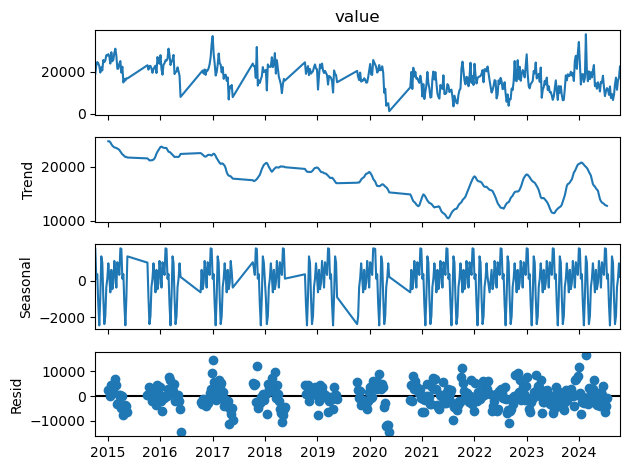

In [31]:
for i in ['LU']:
    print(f"Processing location: {i}")
    data = ari[ari['location']==i]
    data.set_index('truth_date', inplace=True)

    # Decompose series
    result = seasonal_decompose(data['value'], model='additive', period=26)
    resid = result.resid.dropna()
    result.plot()
    # Detect outliers in residuals
    z_scores = (resid - resid.mean()) / resid.std()
    outliers = np.abs(z_scores) > 3
    
    outlier_dates = resid.index[outliers]
    outlier_df = data.loc[outlier_dates, ['value']].copy()
    print(outlier_df)  

Processing location: LU
              value
truth_date         
2018-01-28  13100.0
2019-02-17   9200.0
2022-04-17  12500.0
2022-12-18  14600.0
2022-12-25  17900.0
2023-01-01  16800.0
Processing location: MT
              value
truth_date         
2017-01-01  13600.0
2018-01-07  18300.0
2018-01-14  17800.0
Processing location: LV
                 value
truth_date            
2024-01-28  442.299988
2024-02-04  479.700012
2024-02-11  519.900024
2024-02-18  530.700012
2024-02-25  467.200012


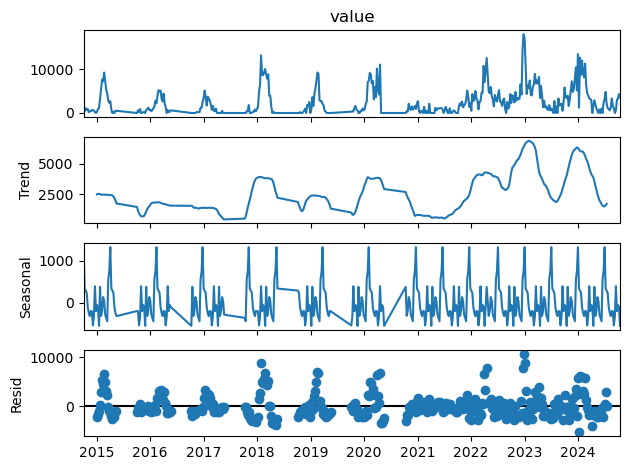

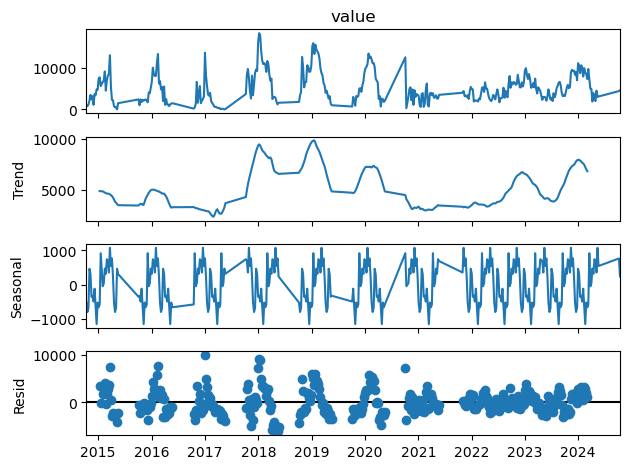

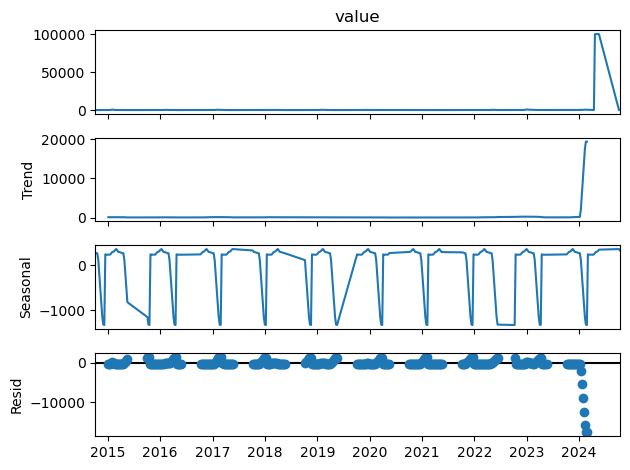

In [37]:
for i in ['LU','MT','LV']:
    print(f"Processing location: {i}")
    data = ili[ili['location']==i]
    data.set_index('truth_date', inplace=True)

    # Decompose series
    result = seasonal_decompose(data['value'], model='additive', period=26)
    resid = result.resid.dropna()
    result.plot()
    # Detect outliers in residuals
    z_scores = (resid - resid.mean()) / resid.std()
    outliers = np.abs(z_scores) > 3
    
    outlier_dates = resid.index[outliers]
    outlier_df = data.loc[outlier_dates, ['value']].copy()
    print(outlier_df)  

In [35]:
data

,location,year_week,value,relative_humidity_2m,temperature_2m_max,temperature_2m_min,covid
truth_date,,,,,,,
2014-10-05,LU,2014-W40,18900.0,90.840320,15.033501,11.758500,0
2014-10-12,LU,2014-W41,23000.0,90.076416,16.287071,9.765642,0
2014-10-19,LU,2014-W42,24500.0,88.561790,16.865643,9.744215,0
2014-10-26,LU,2014-W43,23900.0,86.718025,12.265643,7.094214,0
2014-11-02,LU,2014-W44,22600.0,92.751880,13.858500,7.629929,0
...,...,...,...,...,...,...,...
2024-09-15,LU,2024-W37,17100.0,78.225030,15.022786,7.094214,0
2024-09-22,LU,2024-W38,11300.0,74.516250,21.158499,11.801358,0
2024-09-29,LU,2024-W39,15700.0,84.968370,14.158501,8.194215,0


Processing location: LU


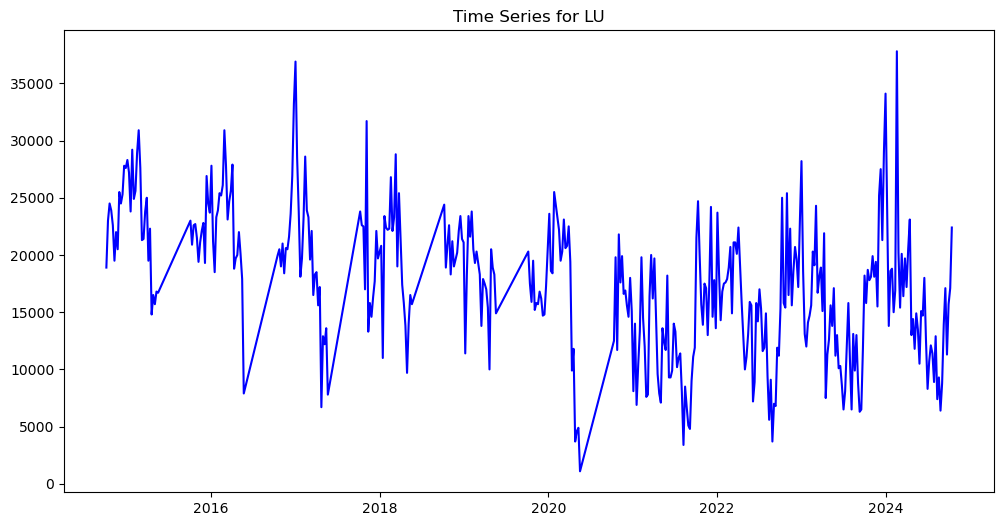

In [34]:
for i in ['LU']:
    
    data = ari[ari['location']==i]
    data.set_index('truth_date', inplace=True)

    plt.figure(figsize=(12, 6))
    print(f"Processing location: {i}")
    plt.plot(data.index, data["value"], color='blue', label='Training Data')
    plt.title(f"Time Series for {i}")

Processing location: LU
Processing location: MT
Processing location: LV


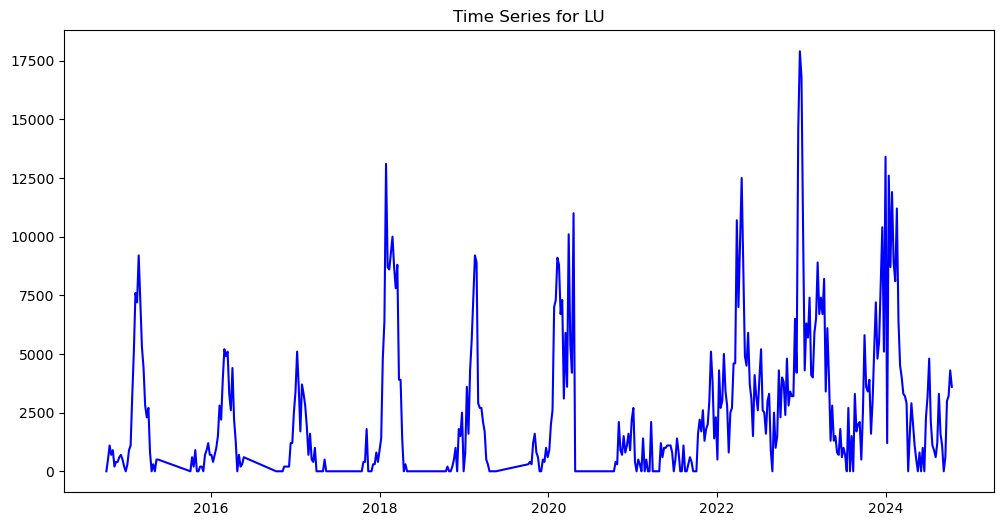

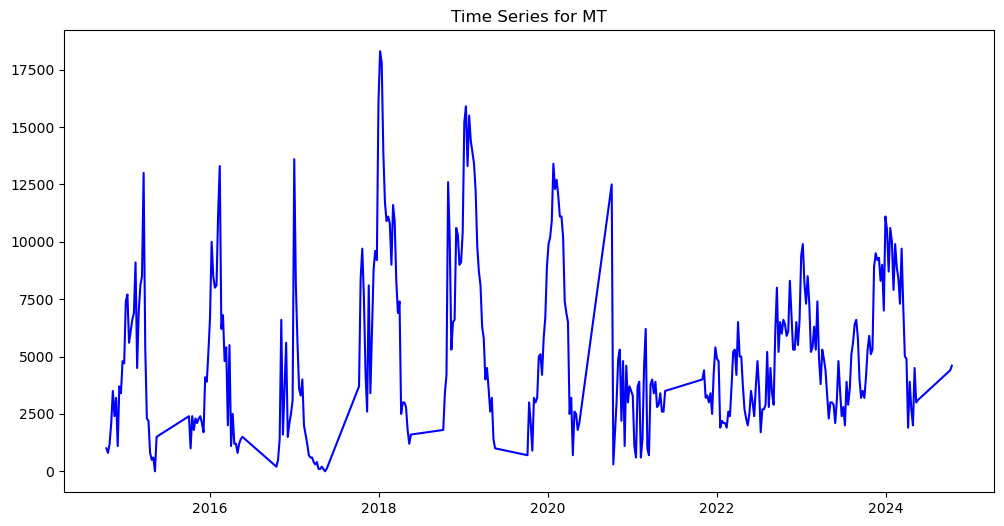

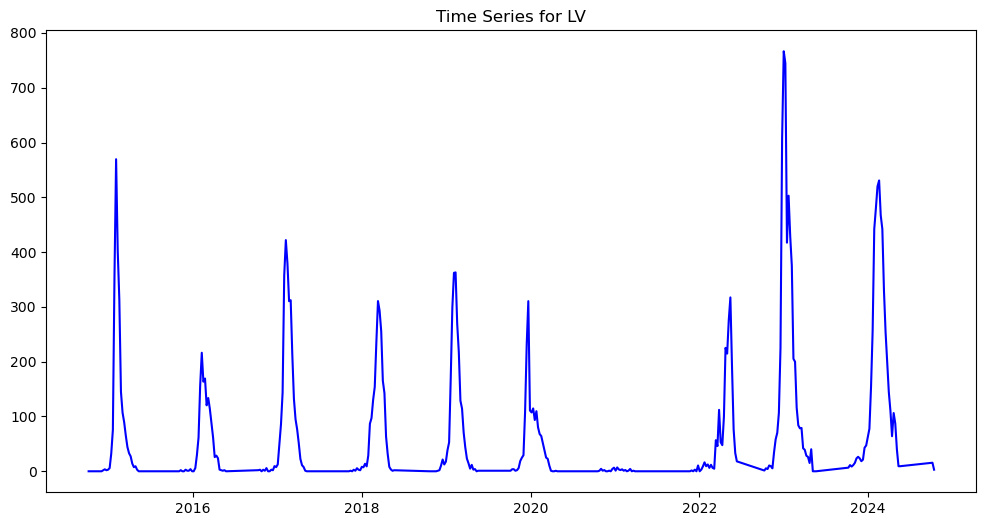

In [8]:
import matplotlib.pyplot as plt
for i in ['LU','MT','LV']:
    
    data = ili[ili['location']==i]
    data.set_index('truth_date', inplace=True)

    plt.figure(figsize=(12, 6))
    print(f"Processing location: {i}")
    plt.plot(data.index, data["value"], color='blue', label='Training Data')
    plt.title(f"Time Series for {i}")

In [9]:
ili.to_csv('data_ili.csv')

Processing location: LV


Text(0.5, 1.0, 'Time Series for LV')

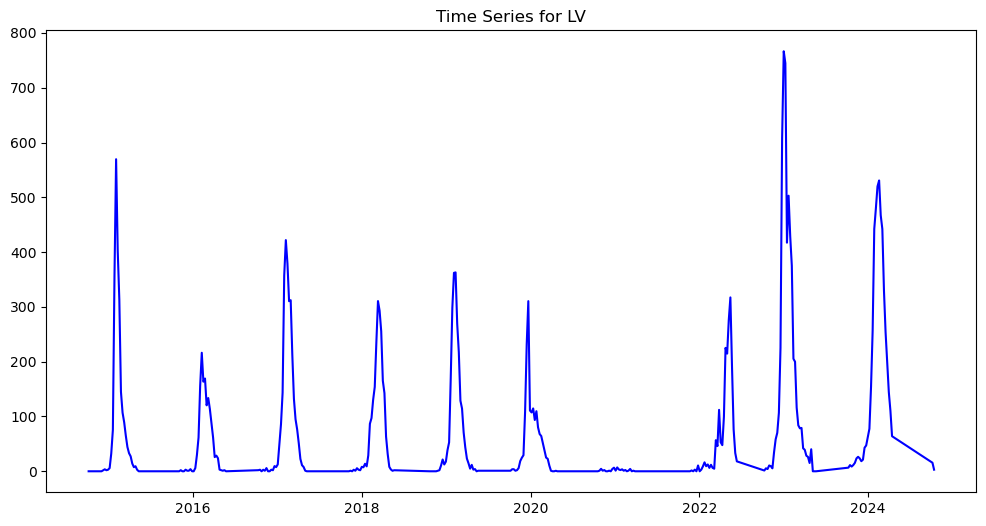

In [44]:
data2 = ili[ili['location']=='LV']
data2 = data2[data2['value']<2000]

data2.set_index('truth_date', inplace=True)

plt.figure(figsize=(12, 6))
print(f"Processing location: {i}")
plt.plot(data2.index, data2["value"], color='blue', label='Training Data')
plt.title(f"Time Series for {i}")

In [46]:
data2['year'] = data2.index.year

In [68]:
ili['year'] = ili['truth_date'].dt.year

In [69]:
ili['location'].unique()

array(['SI', 'DK', 'EE', 'PL', 'FR', 'AT', 'HR', 'RO', 'GR', 'HU', 'IE',
       'LV', 'BE', 'LU', 'LT', 'NL', 'CZ', 'NO', 'MT'], dtype=object)

In [90]:
ili[ili['location']=='MT'].groupby(['location','year']).count()

truth_date  year_week  value  relative_humidity_2m  \
location year                                                       
MT       2014          12         12     12                    12   
         2015          32         32     32                    32   
         2016          32         32     32                    32   
         2017          34         34     34                    34   
         2018          33         33     33                    33   
         2019          33         33     33                    33   
         2020          32         32     32                    32   
         2021          30         30     30                    30   
         2022          52         52     52                    52   
         2023          52         52     52                    52   
         2024          22         22     22                    22   

               temperature_2m_max  temperature_2m_min  covid  
location year                                                 
MT       2014                  12                  12     12  
         2015                  32                  32     32  
         2016                  32                  32     32  
         2017                  34                  34     34  
         2018                  33                  33     33  
         2019                  33                  33     33  
         2020                  32                  32     32  
         2021                  30                  30     30  
         2022                  52                  52     52  
         2023                  52                  52     52  
         2024                  22                  22     22

                 value
truth_date            
2015-02-01  569.500000
2017-02-05  421.899994
2022-12-25  607.900024
2023-01-01  766.500000
2023-01-08  744.799988


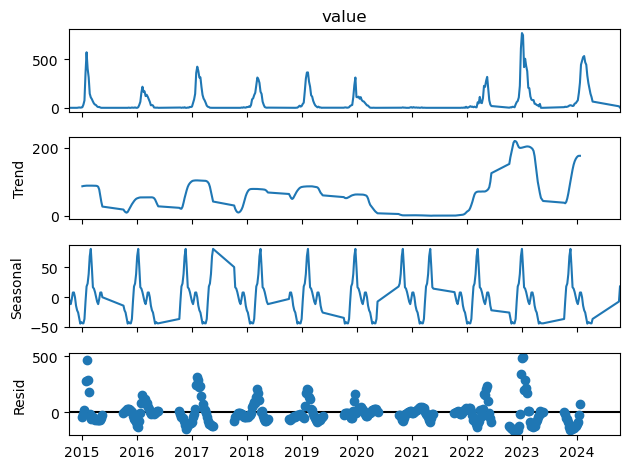

In [43]:
# Decompose series
result = seasonal_decompose(data2['value'], model='additive', period=26)
resid = result.resid.dropna()
result.plot()
# Detect outliers in residuals
z_scores = (resid - resid.mean()) / resid.std()
outliers = np.abs(z_scores) > 3

outlier_dates = resid.index[outliers]
outlier_df = data.loc[outlier_dates, ['value']].copy()
print(outlier_df)  